In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#don't run this part
%cd gdrive/My\ Drive/data

/content/gdrive/My Drive/data


In [3]:
#ignore this part
!nvidia-smi

Sat Nov 20 16:07:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
#1
# Importing the libraries
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from tqdm import tqdm

In [25]:
def classFreqPlot(y):
  y = pd.DataFrame(y)
  classFreq = y[0].value_counts()
  print(classFreq)
  classFreq.plot.barh()
  plt.show()

In [55]:
RNADf = pd.read_csv('train.csv')
RNADf.dropna(inplace=True)
print(RNADf.shape)
RNADs = RNADf.to_numpy()
RNADf.head()
# classFreqPlot(y)

(6394, 2)


Sequence   Label
0  AAAFVNQHLCGSHLVEAL       0
1        AAAKEAEAHEEI       1
2     AAALPGQPESPDIPG       1
3       AAALPGQPPDIPG       1
4  AACFKEGSFDEDGFYAKV       0

In [56]:
# only run this for performing undersampling
ones = len(RNADf[RNADf[' Label'] == 1])
print(ones)
zerosInd = RNADf[RNADf[' Label'] == 0].index
print(zerosInd)
random_indicesOfZeros = np.random.choice(zerosInd,ones, replace=False) # 2*ones means 0's will be twice as ones
oneIndices = RNADf[RNADf[' Label'] == 1].index
under_sample_indices = np.concatenate([oneIndices,random_indicesOfZeros])
under_sampleDf = RNADf.loc[under_sample_indices]
RNADs = under_sampleDf.to_numpy()

3197
Int64Index([   0,    4,    5,    8,    9,   10,   11,   12,   13,   14,
            ...
            6362, 6367, 6368, 6370, 6371, 6380, 6383, 6385, 6390, 6391],
           dtype='int64', length=3197)


In [57]:
X = RNADs[:,0]
y = RNADs[:,1]

## converting seq into features

### using one hot encoding

In [58]:
# ch=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y','X']
# newX = []
# for s in range(len(X)):
#   seq = X[s]
#   temp = []
#   for letter in seq:
#     for i in ch:
#       if(i == letter):
#         temp.append(1)
#       else:
#         temp.append(0)
#   newX.append(temp)
# X = newX
# classFreqPlot(y)
# print(X[:2])

### using dictionary (indexing of letter pair and triplets)
for eg: ECAE would become 1,1,0,2,0,0,0,,,, (E is twice), similarly for pairs and trip


{'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19, 'X': 20, 'LL': 21, 'GG': 22, 'SS': 23, 'SL': 24, 'SG': 25, 'EE': 26, 'KE': 27, 'PG': 28, 'EK': 29, 'LE': 30, 'KK': 31, 'LS': 32, 'TL': 33, 'AL': 34, 'EL': 35, 'LLL': 36, 'GGG': 37, 'SSS': 38, 'SLL': 39, 'SGG': 40, 'EEE': 41, 'KEE': 42}


100%|██████████| 6394/6394 [00:00<00:00, 12524.69it/s]


(6394, 44)
['AFSFEAQGGLA']
[[3. 0. 0. 1. 2. 2. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
1    3197
0    3197
Name: 0, dtype: int64


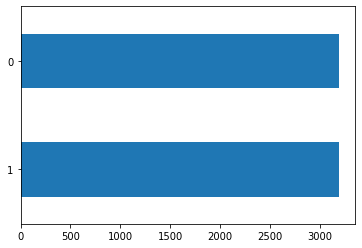

In [59]:
#converting features from 1 column to 20 columns 
npairs = 15
ntriplets = 7
nquads = 0
letters = 21
lettInd = {'A': 0, 'C':1, 'D':2 , 'E':3 , 'F':4 , 'G':5, 'H':6, 'I':7 , 'K':8, 'L':9, 'M':10 , 'N':11 ,'P':12 , 'Q':13 , 'R':14 , 'S':15 , 'T':16, 'V':17, 'W':18, 'Y':19, 'X':20 }
newX = np.empty((len(X), nquads+ntriplets+npairs+letters + 1))
pairs = {}
triplets = {}
quad = {}
for i in range(len(X)):
  x = X[i]
  for j in range(len(x)-1):
    a = x[j]; b = x[j+1]
    # print(a,b)
    # if(a != "X" and b != "X"):
    if(a+""+b in pairs):
      pairs[a+""+b] += 1
    else:
      pairs[a+""+b] = 1
  for j in range(len(x)-2):
      a = x[j]; b = x[j+1]; c = x[j+1]
      # if(a != 'X' and b != 'X' and x != 'X'):
      if(a+""+b+""+c in triplets):
        triplets[a+""+b+""+c] += 1
      else:
        triplets[a+""+b+""+c] = 1
  for j in range(len(x)-3):
      a = x[j]; b = x[j+1]; c = x[j+1]; d = x[j+2]
      # if(a != 'X' and b != 'X' and x != 'X'):
      if(a+""+b+""+c+""+d in quad):
        quad[a+""+b+""+c+""+d] += 1
      else:
        quad[a+""+b+""+c+""+d] = 1
pairs = dict(sorted(pairs.items(), key=lambda item: item[1], reverse = True))
triplets = dict(sorted(triplets.items(), key=lambda item: item[1], reverse = True))
quad = dict(sorted(quad.items(), key=lambda item: item[1], reverse = True))

pairsKeys = list(pairs.keys())
tripletsKeys = list(triplets.keys())
quadKeys = list(quad.keys())
# print(pairsKeys)
# print(tripletskeys)
for i in range(npairs):
  lettInd[pairsKeys[i]] = letters+i
for i in range(ntriplets):
  lettInd[tripletsKeys[i]] = letters+npairs+i   
for i in range(nquads):
  lettInd[tripletsKeys[i]] = letters+npairs+ntriplets+i     
print(lettInd)   
for i in tqdm(range(len(X))):
  x = X[i]
  temp = np.zeros(nquads+ntriplets+npairs+letters+1)
  for j in x:
    # if(j != 'X'):
    if(j == '\ufeff'):
      temp[-1] = 1
    else:
      index = lettInd[j]
      temp[index] += 1
  for j in range(len(x)-1):
      a = x[j]; b = x[j+1]
      # if(a != "X" and b != "X"):
      if(a+""+b in lettInd):
        index = lettInd[a+""+b]
        temp[index] += 1
  for j in range(len(x)-2):
      a = x[j]; b = x[j+1]; c = x[j+1]
      # if(a != 'X' and b != 'X' and x != 'X'):
      if(a+""+b+""+c in lettInd):
        index = lettInd[a+""+b+""+c]
        temp[index] += 1
  for j in range(len(x)-3):
      a = x[j]; b = x[j+1]; c = x[j+1]; d = x[j+2]
      if(a+""+b+""+c+""+d in lettInd):
        index = lettInd[a+""+b+""+c+""+d]
        temp[index] += 1
 
  
  newX[i] = temp
      
print(newX.shape)
print(X[29:30])
print(newX[29:30])
# print(np.sum(newX[:,21]))
oldX = X
X = newX
classFreqPlot(y)

In [60]:
print(pairs)
print(lettInd)   
n_features = 20+nquads+npairs+ntriplets+1
print(np.sum(newX[:,n_features]))

{'LL': 747, 'GG': 668, 'SS': 661, 'SL': 627, 'SG': 614, 'EE': 597, 'KE': 563, 'PG': 556, 'EK': 554, 'LE': 534, 'KK': 533, 'LS': 531, 'TL': 531, 'AL': 527, 'EL': 525, 'LA': 519, 'AA': 515, 'TS': 512, 'AS': 501, 'DG': 492, 'GS': 488, 'VL': 475, 'AG': 474, 'GE': 474, 'GT': 474, 'LG': 463, 'GL': 461, 'LK': 461, 'SE': 460, 'GK': 460, 'ED': 459, 'DL': 458, 'ST': 457, 'LD': 457, 'GA': 455, 'TG': 451, 'KL': 450, 'TT': 450, 'LT': 449, 'VS': 446, 'SA': 445, 'EA': 444, 'KD': 444, 'GD': 440, 'EV': 439, 'SD': 439, 'VT': 438, 'LP': 436, 'LV': 435, 'EN': 434, 'PP': 429, 'KS': 427, 'LR': 427, 'DE': 427, 'DS': 420, 'AE': 418, 'TA': 414, 'IT': 413, 'TV': 412, 'SV': 404, 'NN': 404, 'AV': 404, 'SK': 403, 'DK': 403, 'GV': 401, 'LI': 400, 'ET': 400, 'ES': 397, 'GR': 396, 'VA': 396, 'LN': 395, 'GP': 394, 'VE': 393, 'VV': 393, 'EI': 392, 'EG': 392, 'VK': 391, 'PS': 390, 'RG': 389, 'DD': 386, 'AK': 384, 'DI': 384, 'KT': 382, 'SN': 381, 'TE': 380, 'KN': 379, 'ER': 379, 'NL': 377, 'IL': 376, 'RL': 376, 'PE': 372

In [33]:
# run this for performing upsampling (may take around 41 sec)
# from imblearn.over_sampling import SMOTE 
# sm = SMOTE(random_state = 2, k_neighbors=5, sampling_strategy = 1, n_jobs = -1) 
# X, y = sm.fit_sample(X, y)
# classFreqPlot(y)
# print(X[:3])

### self written code for oversampling (don't run)
as undersampling performing better 

In [ ]:
# print(X[:10])
# print(y[:10])
# newX = []
# for i in range(len(X)):
#   if(y[i] == 1):
#     for j in range(20):
#       newX.append([X[i], y[i]])
#   else:
#     newX.append([X[i], y[i]])
# import random
# random.shuffle(newX)
# for i in range(len(X)):
#   X[i] = newX[i][0]
#   y[i] = newX[i][1]
# classFreqPlot(y)
# print(X[:10])
# print(y[:10])

### for feature selection 

In [ ]:
# from sklearn.feature_selection import RFE
# from sklearn.ensemble import RandomForestClassifier 
# RFclf = RandomForestClassifier(max_depth = 27, bootstrap = True, n_estimators = 100, criterion = 'gini', random_state = 1,n_jobs = -1, verbose = 1)
# selector = RFE(RFclf, n_features_to_select=30, step=1)
# selector = selector.fit(X, y)
# selector.support_

In [ ]:
# selector.ranking_

In [ ]:
# X = X[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,34]] #choosing feature accordingly

In [ ]:
# #skip this part (not a good way of undersampling)
# from imblearn.under_sampling import NearMiss
# # define the undersampling method
# undersample = NearMiss(version = 1 , n_neighbors=5, random_state=1,sampling_strategy=0.8)
# X, y = undersample.fit_resample(X, y)
# print(len(y))
# print(sum(y))
# classFreqPlot(y)

In [ ]:
# # #for feature reduction (not needed)
# from sklearn.decomposition import PCA
# pca=PCA(5) # else some column will have std as 0 and due to which divide by 0 error
# pcaX=pca.fit_transform(X)
# print("Features after PCA:",len(pcaX[0]))
# X = pcaX

Features after PCA: 5


In [61]:
y = y.astype('i')

## checking for validation score using training and test data

0    2142
1    2141
Name: 0, dtype: int64


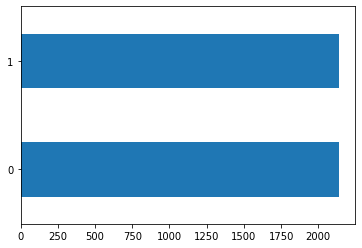

1    1056
0    1055
Name: 0, dtype: int64


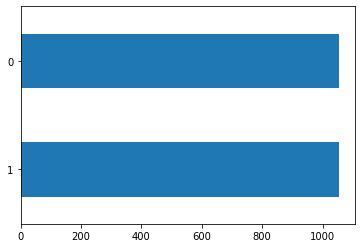

In [62]:
#data splitting for cross validation and grid search

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify = y, random_state=37)
y_train = y_train.astype('i')
y_test  = y_test.astype('i')
#classFreq after trian test split
classFreqPlot(y_train)
classFreqPlot(y_test)

In [ ]:
# ##TSNE for visualization (dont run this section)
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()#,stop_words=stop_words
# X_trainT = vectorizer.fit_transform(X_train)
# X_testT  = vectorizer.transform(X_test)

In [15]:
print(X_train[:2])

[[3. 0. 2. 1. 0. 1. 1. 1. 3. 3. 1. 0. 2. 0. 0. 0. 0. 3. 0. 3. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 1. 1. 4. 0. 0. 0. 4. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1500, 3)
[-10.01134491 -34.73194885   1.        ]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


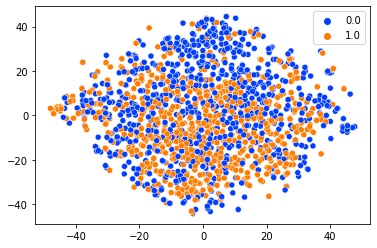

In [ ]:
#no need to run it again
from sklearn.manifold import TSNE
tX_train = TSNE(n_components=2).fit_transform(X_train[:1500]) #taking only first 5000 data for visualization

#adding the label
matYtrain = np.mat(y_train[:1500]).transpose()
XY_train = np.array(np.hstack((tX_train, matYtrain)),dtype = float)
print(XY_train.shape)
print(XY_train[2])
import seaborn as sns
sns.scatterplot(XY_train[:,0],XY_train[:,1],hue=XY_train[:,2], palette="bright")

In [63]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

MNBclf = MultinomialNB()
MNBclf.fit(X_train, y_train)

y_pred = MNBclf.predict(X_test)

print("Accuracy: ",accuracy_score(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test,y_pred))


Accuracy:  0.650876361913785
[[665 390]
 [347 709]]
              precision    recall  f1-score   support

           0       0.66      0.63      0.64      1055
           1       0.65      0.67      0.66      1056

    accuracy                           0.65      2111
   macro avg       0.65      0.65      0.65      2111
weighted avg       0.65      0.65      0.65      2111



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

LOGclf = LogisticRegression(random_state=0, n_jobs = -1, max_iter = 100, verbose= 2)
LOGclf.fit(X_train, y_train)
y_pred = LOGclf.predict(X_test)

#for accuracy using sklearn accuracy_score
AccuracyScore = accuracy_score(y_test, y_pred)
print("Testing accuracy:", AccuracyScore)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Testing accuracy: 0.7072477498815727


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


In [ ]:
from sklearn.neighbors import KNeighborsClassifier #take more than 3 min (1m2s 75), (27m, 90.8%)
KNNclf = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski',n_jobs = -1)
KNNclf.fit(X_train, y_train)
# Predicting the Test set results
y_pred = KNNclf.predict(X_test)
#for accuracy using sklearn accuracy_score
AccuracyScore = accuracy_score(y_test, y_pred)
print("Testing accuracy:", AccuracyScore)

Testing accuracy: 0.6631927996210327


In [ ]:
from sklearn.neighbors import KNeighborsClassifier #take more than 3 min (1m2s 75)
KNNclf = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski',n_jobs = -1)
KNNclf.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
from sklearn.naive_bayes import GaussianNB
GNBclf = GaussianNB()
GNBclf.fit(X_train, y_train)
y_pred = GNBclf.predict(X_test)

print("Accuracy: ",accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

Accuracy:  0.5423969682614874
[[963  92]
 [874 182]]
              precision    recall  f1-score   support

           0       0.52      0.91      0.67      1055
           1       0.66      0.17      0.27      1056

    accuracy                           0.54      2111
   macro avg       0.59      0.54      0.47      2111
weighted avg       0.59      0.54      0.47      2111



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
SVMclf = SVC(probability=False,random_state=1, kernel='rbf')
SVMclf.fit(X_train, y_train)
# Predicting the Test set results
y_pred = SVMclf.predict(X_test)
#for accuracy using sklearn accuracy_score
AccuracyScore = accuracy_score(y_test, y_pred)
print("Testing accuracy:", AccuracyScore)

Testing accuracy: 0.7228801515869256


### grid search cv for random forest hyper parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
grid_param = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 9, 16, 50, 75],
    'criterion': ['gini'],
    'bootstrap': [True]
}

gdsrcv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid_param, scoring='accuracy', cv=4, n_jobs=-1)
gdsrcv.fit(X_train, y_train)
best_parameters = gdsrcv.best_params_
print(best_parameters)

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 9, 'n_estimators': 200}


### for cross validation 

In [ ]:
# for cross validation so that model doesn't overfit 
from sklearn.model_selection import cross_val_score, cross_val_predict
model=RandomForestClassifier()
predictions = cross_val_score(model, X_train, y_train, cv=5)

In [ ]:
from sklearn.ensemble import RandomForestClassifier  #5s 78%
RFclf = RandomForestClassifier(max_depth = 16, bootstrap = True, n_estimators = 300, criterion = 'gini', random_state = 1,n_jobs = -1, verbose = 2)
RFclf.fit(X_train, y_train)

y_pred = RFclf.predict(X_test)
#for accuracy using sklearn accuracy_score
AccuracyScore = accuracy_score(y_test, y_pred)
print("Testing accuracy:", AccuracyScore)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
#12>89.44
#20>95.7
#100, 40, 95.8
#100, 35, 95.88
#100, pca30, 92
#100, w/oPcA 400, 96.03

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.2s



building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300building tree 45 of 300

building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300building tree 65 of 300

building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300building tree 71 of 300

building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300building tree 80 of 300

building tree 8

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    0.9s


building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300
building tree 201 of 300
building tree 202 of 300building tree 203 of 300

building tree 204 of 300
building tree 205 of 300
building tree 206 of 300
building tree 207 of 300
building tree 208 of 300
building tree 209 of 300
building tree 210 of 300
building tree 211 of 300
building tree 212 of 300
building tree 213 of 300
building tree 214 of 300
building tree 215 of 300
building tree 216 of 300
building tree 217 of 300
building tree 218 of 300
building tree 219 of 300
building tree 220 of 300
building tree 221 of 300
building tree 222 of 300
building tree 223 of 300
building tree 224 of 300
building tree 225 of 300
building tree 226 of 300
building tree 227 of 300
building tree 228 of 300building tree 229 of 300

building tree 230 of 300
building tree 231 of 300
building tree 232 of 300
building tree 233 of 300
building tree 234 of 300
building tree 235 of 300


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.2s finished


Testing accuracy: 0.7124585504500237
[[686 369]
 [238 818]]
              precision    recall  f1-score   support

           0       0.74      0.65      0.69      1055
           1       0.69      0.77      0.73      1056

    accuracy                           0.71      2111
   macro avg       0.72      0.71      0.71      2111
weighted avg       0.72      0.71      0.71      2111



In [ ]:
from sklearn.ensemble import RandomForestClassifier #1000 4min, 3000 17 min 
RFclf = RandomForestClassifier(max_depth = 39, bootstrap = True, n_estimators = 500, criterion = 'gini', random_state = 1,n_jobs = -1, verbose = 2)
RFclf.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500building tree 14 of 500

building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.1s


building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   12.8s


building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500


[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   29.0s


building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500building tree 396 of 500

building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500
building tree 403 of 500
building tree 404 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=39, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=2,
                       warm_start=False)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
ETclf = ExtraTreesClassifier(max_depth = 39, bootstrap = True, n_estimators = 300, criterion = 'gini', n_jobs = -1,max_samples=0.8,max_features=31,random_state=37, verbose = 2)
ETclf.fit(X_train, y_train)

y_pred = ETclf.predict(X_test)
#for accuracy using sklearn accuracy_score
AccuracyScore = accuracy_score(y_test, y_pred)
print("Testing accuracy:", AccuracyScore)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
#12>89.44
#20>95.7
#100, 40, 95.8
#100, 35, 95.88
#100, pca30, 92
#100, w/oPcA 400, 96.03

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300building tree 8 of 300

building tree 9 of 300
building tree 10 of 300
building tree 11 of 300building tree 12 of 300

building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.3s


building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82 of 300
building tree 83 of 300
building tree 84 of 300
building tree 85 of 300
building tree 86 of 300
building tree 87 of 300
building tree 88 of 300
building tree 89 of 300
building tree 90 of 300
building tree 91 of 300
building tree 92 of 300
building tree 93 of 300
building tree 94

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    1.3s


building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300building tree 185 of 300

building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300
building tree 201 of 300
building tree 202 of 300
building tree 203 of 300
building tree 204 of 300
building tree 205 of 300
building tree 206 of 300
building tree 207 of 300
building tree 208 of 300
building tree 209 of 300
building tree 210 of 300
building tree 211 of 300
building tree 212 of 300
building tree 213 of 300
building tree 214 of 300building tree 215 of 300

building tree 216 of 300
building tree 217 of 300
building tree 218 of 300building tree 219 of 300



[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.1s


Testing accuracy: 0.7124585504500237
[[721 334]
 [273 783]]
              precision    recall  f1-score   support

           0       0.73      0.68      0.70      1055
           1       0.70      0.74      0.72      1056

    accuracy                           0.71      2111
   macro avg       0.71      0.71      0.71      2111
weighted avg       0.71      0.71      0.71      2111



[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.2s finished


In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
ETclf = ExtraTreesClassifier(max_depth = 39, bootstrap = True, n_estimators = 300, criterion = 'gini', n_jobs = -1,max_samples=0.8,max_features=31,random_state=37, verbose = 2)
ETclf.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.9s


building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74 of 500
building tree 75 of 500
building tree 76 of 500
building tree 77 of 500
building tree 78 of 500
building tree 79 of 500
building tree 80 of 500
building tree 81

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   12.4s


building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500
building tree 200 of 500
building tree 201 of 500


[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   28.4s


building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500
building tree 397 of 500
building tree 398 of 500
building tree 399 of 500
building tree 400 of 500
building tree 401 of 500
building tree 402 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   39.4s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=39, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=2,
                       warm_start=False)

In [ ]:
from sklearn.neural_network import MLPClassifier #(1m 48s 70)
MLPclf = MLPClassifier(batch_size = 512, early_stopping=True, hidden_layer_sizes=(256,128,64,32,16), random_state=37 ,max_iter=350, learning_rate_init=0.01, tol=0.0000001,n_iter_no_change = 20, verbose = True)
MLPclf.fit(X_train, y_train)
# Predicting the Test set results
# print(X_train.shape)
y_pred = MLPclf.predict(X_test)
#for accuracy using sklearn accuracy_score
AccuracyScore = accuracy_score(y_test, y_pred)
print("Testing accuracy:", AccuracyScore)

Iteration 1, loss = 0.69529258
Validation score: 0.671329
Iteration 2, loss = 0.61918966
Validation score: 0.687646
Iteration 3, loss = 0.59019390
Validation score: 0.689977
Iteration 4, loss = 0.57205132
Validation score: 0.706294
Iteration 5, loss = 0.55249996
Validation score: 0.675991
Iteration 6, loss = 0.54728828
Validation score: 0.701632
Iteration 7, loss = 0.53532935
Validation score: 0.680653
Iteration 8, loss = 0.49642570
Validation score: 0.694639
Iteration 9, loss = 0.46957411
Validation score: 0.680653
Iteration 10, loss = 0.46281487
Validation score: 0.692308
Iteration 11, loss = 0.41997239
Validation score: 0.689977
Iteration 12, loss = 0.38705420
Validation score: 0.678322
Iteration 13, loss = 0.37196602
Validation score: 0.678322
Iteration 14, loss = 0.34883066
Validation score: 0.692308
Iteration 15, loss = 0.31784154
Validation score: 0.675991
Iteration 16, loss = 0.29506914
Validation score: 0.655012
Iteration 17, loss = 0.25582624
Validation score: 0.657343
Iterat

In [ ]:
from sklearn.neural_network import MLPClassifier #(1m 48s 70)
MLPclf = MLPClassifier(batch_size = 512, early_stopping=True, hidden_layer_sizes=(256,128,64,32,16), random_state=37 ,max_iter=350, learning_rate_init=0.01, tol=0.0000001,n_iter_no_change = 10, verbose = True)
MLPclf.fit(X, y)

Iteration 1, loss = 0.54768095
Validation score: 0.817184
Iteration 2, loss = 0.34176088
Validation score: 0.883585
Iteration 3, loss = 0.26247484
Validation score: 0.910373
Iteration 4, loss = 0.20912012
Validation score: 0.916785
Iteration 5, loss = 0.18225001
Validation score: 0.932602
Iteration 6, loss = 0.15920985
Validation score: 0.932032
Iteration 7, loss = 0.14712307
Validation score: 0.939014
Iteration 8, loss = 0.12993084
Validation score: 0.948988
Iteration 9, loss = 0.12546995
Validation score: 0.946708
Iteration 10, loss = 0.11506929
Validation score: 0.955115
Iteration 11, loss = 0.10806080
Validation score: 0.955400
Iteration 12, loss = 0.09947976
Validation score: 0.951981
Iteration 13, loss = 0.09171885
Validation score: 0.955543
Iteration 14, loss = 0.08869258
Validation score: 0.960103
Iteration 15, loss = 0.08282324
Validation score: 0.955258
Iteration 16, loss = 0.08011055
Validation score: 0.959533
Iteration 17, loss = 0.07516489
Validation score: 0.958963
Iterat

MLPClassifier(activation='relu', alpha=0.0001, batch_size=512, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(256, 128, 64, 32, 16),
              learning_rate='constant', learning_rate_init=0.01, max_fun=15000,
              max_iter=350, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=37,
              shuffle=True, solver='adam', tol=1e-07, validation_fraction=0.1,
              verbose=True, warm_start=False)

In [ ]:
from xgboost import XGBClassifier #(1m 14s 78)
XGBclf = XGBClassifier(max_depth = 16, n_estimators = 400, n_jobs = -1,random_state=37, verbosity=1)
XGBclf.fit(X_train, y_train)
y_pred = XGBclf.predict(X_test)
#for accuracy using sklearn accuracy_score
AccuracyScore = accuracy_score(y_test, y_pred)
print("Testing accuracy:", AccuracyScore)
print(confusion_matrix(y_test, y_pred))

Testing accuracy: 0.7015632401705353
[[714 341]
 [289 767]]


In [ ]:
from xgboost import XGBClassifier #(1m 14s 78)
XGBclf = XGBClassifier(max_depth = 35, n_estimators = 1000, n_jobs = -1,random_state=37, verbosity=2)
XGBclf.fit(X,y)

[06:59:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 832 extra nodes, 0 pruned nodes, max_depth=19
[06:59:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 728 extra nodes, 0 pruned nodes, max_depth=20
[06:59:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 734 extra nodes, 0 pruned nodes, max_depth=20
[06:59:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 784 extra nodes, 0 pruned nodes, max_depth=20
[06:59:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 776 extra nodes, 0 pruned nodes, max_depth=22
[06:59:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 778 extra nodes, 0 pruned nodes, max_depth=21
[06:59:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 788 extra nodes, 0 pruned nodes, max_depth=19
[06:59:02] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=35,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=37,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=2)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier  #1m 54s 67
ADBclf = AdaBoostClassifier(n_estimators=3000, random_state=37, learning_rate = 0.3, algorithm='SAMME')
ADBclf.fit(X_train, y_train)
y_pred = ADBclf.predict(X_test)
#for accuracy using sklearn accuracy_score
AccuracyScore = accuracy_score(y_test, y_pred)
print("Testing accuracy:", AccuracyScore)
print(confusion_matrix(y_test, y_pred))  
#0.8,1000 > 88.95
#0.8, 100 > 82
#1, 100 > 84.3

Testing accuracy: 0.7048792041686405
[[704 351]
 [272 784]]


In [ ]:
ADBclf.fit(X,y) #8min on upsampled data

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.9,
                   n_estimators=3000, random_state=37)

In [37]:
from sklearn.ensemble import GradientBoostingClassifier #6 min #13s 69 #2m6s 73
GBclf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.9,max_depth=7, random_state=37, verbose = 1)
GBclf.fit(X_train, y_train)
y_pred = GBclf.predict(X_test)
#for accuracy using sklearn accuracy_score
AccuracyScore = accuracy_score(y_test, y_pred)
print("Testing accuracy:", AccuracyScore)
print(confusion_matrix(y_test, y_pred))  
#69.3

      Iter       Train Loss   Remaining Time 
         1           1.1086           10.95s
         2           0.9789           10.19s
         3           0.9084            9.67s
         4           0.8610            9.58s
         5           0.8258            9.55s
         6           0.7860            9.40s
         7           0.7548            9.33s
         8           0.7169            9.25s
         9           0.6852            9.23s
        10           0.6291            9.26s
        20           0.3493            9.04s
        30           0.1953            8.85s
        40           0.0942            8.54s
        50           0.0612            8.28s
        60           0.0351            8.07s
        70           0.0216            7.91s
        80           0.0116            7.78s
        90           0.0065            7.65s
       100           0.0034            7.46s
       200           0.0000            5.57s
       300           0.0000            3.70s
       40

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
# ,
#       ('xg', XGBClassifier(max_depth = 16, n_estimators = 400, n_jobs = -1,random_state=37, verbosity=1)),
estimators = [
      ('rf', RandomForestClassifier(max_depth = 35, bootstrap = True, n_estimators = 200, criterion = 'gini', max_features=12,random_state = 1, min_samples_split= 8, n_jobs = -1, verbose = 2)),
      ('knn', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski',n_jobs = -1)),
      ('et', ExtraTreesClassifier(max_depth = 16, bootstrap = True, n_estimators = 500, criterion = 'gini', n_jobs = -1,max_samples=0.8,max_features=9,random_state=37)),
      ('svc', SVC(probability=False,random_state=1, kernel='rbf')),
      ('xgb', XGBClassifier(max_depth = 16, n_estimators = 400, n_jobs = -1,random_state=37, verbosity=1)),
      ('ab', AdaBoostClassifier(n_estimators=3000, random_state=37, learning_rate = 0.3, algorithm='SAMME')),
      ('mlp', MLPClassifier(batch_size = 200, hidden_layer_sizes=(64,32), random_state=1 ,max_iter=300, alpha = 0.001, warm_start=True,n_iter_no_change = 10, verbose = True))
    ]
STKclf = StackingClassifier( estimators=estimators, final_estimator=LogisticRegression(random_state=0,  max_iter = 200, verbose= 2) )
STKclf.fit(X_train, y_train)
y_pred = STKclf.predict(X_test)
#for accuracy using sklearn accuracy_score
AccuracyScore = accuracy_score(y_test, y_pred)
print("Testing accuracy:", AccuracyScore)
print(confusion_matrix(y_test, y_pred))  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.2s finished


Iteration 1, loss = 0.75165750
Iteration 2, loss = 0.65955842
Iteration 3, loss = 0.63057304
Iteration 4, loss = 0.61093574
Iteration 5, loss = 0.59820793
Iteration 6, loss = 0.58897658
Iteration 7, loss = 0.58274593
Iteration 8, loss = 0.57788870
Iteration 9, loss = 0.57088367
Iteration 10, loss = 0.56600201
Iteration 11, loss = 0.56135005
Iteration 12, loss = 0.55722148
Iteration 13, loss = 0.55239452
Iteration 14, loss = 0.54729169
Iteration 15, loss = 0.54352380
Iteration 16, loss = 0.53865723
Iteration 17, loss = 0.53449845
Iteration 18, loss = 0.52914124
Iteration 19, loss = 0.52650806
Iteration 20, loss = 0.52108612
Iteration 21, loss = 0.51663144
Iteration 22, loss = 0.51091890
Iteration 23, loss = 0.50828703
Iteration 24, loss = 0.50160223
Iteration 25, loss = 0.49791976
Iteration 26, loss = 0.49271205
Iteration 27, loss = 0.48937797
Iteration 28, loss = 0.48512892
Iteration 29, loss = 0.48149192
Iteration 30, loss = 0.47836921
Iteration 31, loss = 0.47139200
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.1s

Iteration 1, loss = 0.76982310
Iteration 2, loss = 0.67075252
Iteration 3, loss = 0.64285792
Iteration 4, loss = 0.62405251
Iteration 5, loss = 0.61048488
Iteration 6, loss = 0.59960918
Iteration 7, loss = 0.59101188
Iteration 8, loss = 0.58700765
Iteration 9, loss = 0.58004626
Iteration 10, loss = 0.57411085
Iteration 11, loss = 0.56829699
Iteration 12, loss = 0.56347323
Iteration 13, loss = 0.55970009
Iteration 14, loss = 0.55438621
Iteration 15, loss = 0.55006685
Iteration 16, loss = 0.54570858
Iteration 17, loss = 0.54242614
Iteration 18, loss = 0.53899900
Iteration 19, loss = 0.53289024
Iteration 20, loss = 0.52789044
Iteration 21, loss = 0.52572201
Iteration 22, loss = 0.52044284
Iteration 23, loss = 0.51812563
Iteration 24, loss = 0.51182077
Iteration 25, loss = 0.50738750
Iteration 26, loss = 0.50508213
Iteration 27, loss = 0.49976175
Iteration 28, loss = 0.49511323
Iteration 29, loss = 0.49021903
Iteration 30, loss = 0.48627061
Iteration 31, loss = 0.48273217
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 5, loss = 0.60910397
Iteration 6, loss = 0.59907796
Iteration 7, loss = 0.59231078
Iteration 8, loss = 0.58670374
Iteration 9, loss = 0.58097392
Iteration 10, loss = 0.57569697
Iteration 11, loss = 0.56982833
Iteration 12, loss = 0.56484029
Iteration 13, loss = 0.56062798
Iteration 14, loss = 0.55640187
Iteration 15, loss = 0.55084102
Iteration 16, loss = 0.54667320
Iteration 17, loss = 0.54269032
Iteration 18, loss = 0.53878553
Iteration 19, loss = 0.53448669
Iteration 20, loss = 0.52941810
Iteration 21, loss = 0.52558812
Iteration 22, loss = 0.52020991
Iteration 23, loss = 0.51801506
Iteration 24, loss = 0.51314436
Iteration 25, loss = 0.50685454
Iteration 26, loss = 0.50617537
Iteration 27, loss = 0.50196047
Iteration 28, loss = 0.49640045
Iteration 29, loss = 0.48974165
Iteration 30, loss = 0.48594934
Iteration 31, loss = 0.48192470
Iteration 32, loss = 0.47726808
Iteration 33, loss = 0.47196010
Iteration 34, loss = 0.46957135
Iteration 35, loss = 0.46560359
Iteration 36,

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 2, loss = 0.67128646
Iteration 3, loss = 0.64081518
Iteration 4, loss = 0.62083994
Iteration 5, loss = 0.60557535
Iteration 6, loss = 0.59396586
Iteration 7, loss = 0.58606227
Iteration 8, loss = 0.57984395
Iteration 9, loss = 0.57518321
Iteration 10, loss = 0.56930522
Iteration 11, loss = 0.56344794
Iteration 12, loss = 0.55757932
Iteration 13, loss = 0.55396951
Iteration 14, loss = 0.54999450
Iteration 15, loss = 0.54523204
Iteration 16, loss = 0.54129544
Iteration 17, loss = 0.53811142
Iteration 18, loss = 0.53551695
Iteration 19, loss = 0.53074881
Iteration 20, loss = 0.52580581
Iteration 21, loss = 0.52106967
Iteration 22, loss = 0.51713600
Iteration 23, loss = 0.51469489
Iteration 24, loss = 0.51077913
Iteration 25, loss = 0.50502459
Iteration 26, loss = 0.50173267
Iteration 27, loss = 0.49613952
Iteration 28, loss = 0.49279402
Iteration 29, loss = 0.48955045
Iteration 30, loss = 0.48570705
Iteration 31, loss = 0.47858014
Iteration 32, loss = 0.47588368
Iteration 33, lo

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 6, loss = 0.59832774
Iteration 7, loss = 0.58814876
Iteration 8, loss = 0.58289331
Iteration 9, loss = 0.57707523
Iteration 10, loss = 0.57255260
Iteration 11, loss = 0.56691671
Iteration 12, loss = 0.56284956
Iteration 13, loss = 0.55804625
Iteration 14, loss = 0.55386911
Iteration 15, loss = 0.54939532
Iteration 16, loss = 0.54628433
Iteration 17, loss = 0.54032322
Iteration 18, loss = 0.54031022
Iteration 19, loss = 0.53281913
Iteration 20, loss = 0.52879789
Iteration 21, loss = 0.52278082
Iteration 22, loss = 0.52213256
Iteration 23, loss = 0.52215504
Iteration 24, loss = 0.51645409
Iteration 25, loss = 0.50817816
Iteration 26, loss = 0.50313620
Iteration 27, loss = 0.50062305
Iteration 28, loss = 0.49709160
Iteration 29, loss = 0.49264376
Iteration 30, loss = 0.48845931
Iteration 31, loss = 0.48433823
Iteration 32, loss = 0.47953564
Iteration 33, loss = 0.47606218
Iteration 34, loss = 0.47327917
Iteration 35, loss = 0.47160978
Iteration 36, loss = 0.46558471
Iteration 37

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 3, loss = 0.64151898
Iteration 4, loss = 0.62206047
Iteration 5, loss = 0.60950933
Iteration 6, loss = 0.59938189
Iteration 7, loss = 0.59113491
Iteration 8, loss = 0.58378039
Iteration 9, loss = 0.57861831
Iteration 10, loss = 0.57439895
Iteration 11, loss = 0.56925407
Iteration 12, loss = 0.56454450
Iteration 13, loss = 0.56050822
Iteration 14, loss = 0.55667530
Iteration 15, loss = 0.55520842
Iteration 16, loss = 0.55174476
Iteration 17, loss = 0.54568862
Iteration 18, loss = 0.54417372
Iteration 19, loss = 0.53775927
Iteration 20, loss = 0.53253818
Iteration 21, loss = 0.52862187
Iteration 22, loss = 0.52892867
Iteration 23, loss = 0.52453578
Iteration 24, loss = 0.52060354
Iteration 25, loss = 0.51316056
Iteration 26, loss = 0.50902777
Iteration 27, loss = 0.50540789
Iteration 28, loss = 0.50227104
Iteration 29, loss = 0.49810210
Iteration 30, loss = 0.49316304
Iteration 31, loss = 0.49043709
Iteration 32, loss = 0.48449843
Iteration 33, loss = 0.48007960
Iteration 34, l

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished


Testing accuracy: 0.7252486972998579
[[740 315]
 [265 791]]


## Now training our final model for unseen data

###  Model no. 1 

In [64]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
estimators = [
     ('rf', RandomForestClassifier(max_depth = 35, bootstrap = True, n_estimators = 200, criterion = 'gini', max_features=12,random_state = 1, min_samples_split= 8, n_jobs = -1, verbose = 2)),
      ('knn', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski',n_jobs = -1)),
      ('et', ExtraTreesClassifier(max_depth = 16, bootstrap = True, n_estimators = 500, criterion = 'gini', n_jobs = -1,max_samples=0.8,max_features=9,random_state=37)),
      ('svc', SVC(probability=False,random_state=1, kernel='rbf')),
      ('xgb', XGBClassifier(max_depth = 16, n_estimators = 400, n_jobs = -1,random_state=37, verbosity=1)),
      ('ab', AdaBoostClassifier(n_estimators=3000, random_state=37, learning_rate = 0.3, algorithm='SAMME')),
      ('mlp', MLPClassifier(batch_size = 200, hidden_layer_sizes=(64,32), random_state=1 ,max_iter=300, alpha = 0.001, warm_start=True,n_iter_no_change = 10, verbose = True))
    ]
STKclf = StackingClassifier( estimators=estimators, final_estimator=LogisticRegression(random_state=0,  max_iter = 200, verbose= 2) )
STKclf.fit(X, y)
clf = STKclf

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.8s finished


Iteration 1, loss = 0.70247596
Iteration 2, loss = 0.62419580
Iteration 3, loss = 0.59680741
Iteration 4, loss = 0.58498678
Iteration 5, loss = 0.57693836
Iteration 6, loss = 0.57072852
Iteration 7, loss = 0.56496827
Iteration 8, loss = 0.56120935
Iteration 9, loss = 0.55557163
Iteration 10, loss = 0.55110834
Iteration 11, loss = 0.54710283
Iteration 12, loss = 0.54353564
Iteration 13, loss = 0.53838521
Iteration 14, loss = 0.53330698
Iteration 15, loss = 0.53089384
Iteration 16, loss = 0.52725240
Iteration 17, loss = 0.52257768
Iteration 18, loss = 0.51796304
Iteration 19, loss = 0.51562964
Iteration 20, loss = 0.51293440
Iteration 21, loss = 0.50680611
Iteration 22, loss = 0.50607524
Iteration 23, loss = 0.50012289
Iteration 24, loss = 0.49615946
Iteration 25, loss = 0.49410859
Iteration 26, loss = 0.48887546
Iteration 27, loss = 0.48639676
Iteration 28, loss = 0.48118444
Iteration 29, loss = 0.47741457
Iteration 30, loss = 0.47345822
Iteration 31, loss = 0.47236180
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.1s

Iteration 1, loss = 0.71496114
Iteration 2, loss = 0.64237956
Iteration 3, loss = 0.61067752
Iteration 4, loss = 0.59603676
Iteration 5, loss = 0.58613968
Iteration 6, loss = 0.58047706
Iteration 7, loss = 0.57430573
Iteration 8, loss = 0.57030375
Iteration 9, loss = 0.56456996
Iteration 10, loss = 0.56083052
Iteration 11, loss = 0.55646740
Iteration 12, loss = 0.55214257
Iteration 13, loss = 0.54686414
Iteration 14, loss = 0.54308350
Iteration 15, loss = 0.53859066
Iteration 16, loss = 0.53363451
Iteration 17, loss = 0.53034024
Iteration 18, loss = 0.52598716
Iteration 19, loss = 0.52249868
Iteration 20, loss = 0.51721720
Iteration 21, loss = 0.51204039
Iteration 22, loss = 0.50715725
Iteration 23, loss = 0.50264054
Iteration 24, loss = 0.49867843
Iteration 25, loss = 0.49546039
Iteration 26, loss = 0.49149223
Iteration 27, loss = 0.48528394
Iteration 28, loss = 0.48355040
Iteration 29, loss = 0.47763923
Iteration 30, loss = 0.47505793
Iteration 31, loss = 0.46939563
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 4, loss = 0.58720347
Iteration 5, loss = 0.57634457
Iteration 6, loss = 0.57017168
Iteration 7, loss = 0.56368563
Iteration 8, loss = 0.55900342
Iteration 9, loss = 0.55306273
Iteration 10, loss = 0.54879012
Iteration 11, loss = 0.54434898
Iteration 12, loss = 0.54057911
Iteration 13, loss = 0.53415359
Iteration 14, loss = 0.53066845
Iteration 15, loss = 0.52598757
Iteration 16, loss = 0.52179901
Iteration 17, loss = 0.52037903
Iteration 18, loss = 0.51311008
Iteration 19, loss = 0.51019669
Iteration 20, loss = 0.50615825
Iteration 21, loss = 0.50199993
Iteration 22, loss = 0.49651310
Iteration 23, loss = 0.49283463
Iteration 24, loss = 0.48924751
Iteration 25, loss = 0.48519090
Iteration 26, loss = 0.48222308
Iteration 27, loss = 0.47705196
Iteration 28, loss = 0.47474350
Iteration 29, loss = 0.46868187
Iteration 30, loss = 0.46670965
Iteration 31, loss = 0.46081667
Iteration 32, loss = 0.45620445
Iteration 33, loss = 0.45506878
Iteration 34, loss = 0.44879190
Iteration 35, 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 3, loss = 0.59855848
Iteration 4, loss = 0.58405505
Iteration 5, loss = 0.57588111
Iteration 6, loss = 0.57088156
Iteration 7, loss = 0.56475662
Iteration 8, loss = 0.55943999
Iteration 9, loss = 0.55293799
Iteration 10, loss = 0.54901604
Iteration 11, loss = 0.54350926
Iteration 12, loss = 0.53951094
Iteration 13, loss = 0.53384254
Iteration 14, loss = 0.52993729
Iteration 15, loss = 0.52630145
Iteration 16, loss = 0.52098627
Iteration 17, loss = 0.51661593
Iteration 18, loss = 0.51404686
Iteration 19, loss = 0.50962230
Iteration 20, loss = 0.50455586
Iteration 21, loss = 0.50057297
Iteration 22, loss = 0.49497935
Iteration 23, loss = 0.49006142
Iteration 24, loss = 0.48661917
Iteration 25, loss = 0.48175102
Iteration 26, loss = 0.47800067
Iteration 27, loss = 0.47485227
Iteration 28, loss = 0.47001690
Iteration 29, loss = 0.46487993
Iteration 30, loss = 0.46264986
Iteration 31, loss = 0.45779551
Iteration 32, loss = 0.45155401
Iteration 33, loss = 0.45226170
Iteration 34, l

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.72157285
Iteration 2, loss = 0.64100119
Iteration 3, loss = 0.60881744
Iteration 4, loss = 0.59193031
Iteration 5, loss = 0.58216661
Iteration 6, loss = 0.57681126
Iteration 7, loss = 0.56996279
Iteration 8, loss = 0.56442483
Iteration 9, loss = 0.55886053
Iteration 10, loss = 0.55488988
Iteration 11, loss = 0.55017128
Iteration 12, loss = 0.54562733
Iteration 13, loss = 0.54039216
Iteration 14, loss = 0.53669211
Iteration 15, loss = 0.53442757
Iteration 16, loss = 0.52888980
Iteration 17, loss = 0.52672271
Iteration 18, loss = 0.52305304
Iteration 19, loss = 0.51894109
Iteration 20, loss = 0.51522241
Iteration 21, loss = 0.51228005
Iteration 22, loss = 0.50704220
Iteration 23, loss = 0.50304930
Iteration 24, loss = 0.50055391
Iteration 25, loss = 0.49644215
Iteration 26, loss = 0.49478466
Iteration 27, loss = 0.49040346
Iteration 28, loss = 0.48684240
Iteration 29, loss = 0.48161251
Iteration 30, loss = 0.47875539
Iteration 31, loss = 0.47569070
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.71849831
Iteration 2, loss = 0.63357242
Iteration 3, loss = 0.60058519
Iteration 4, loss = 0.58352014
Iteration 5, loss = 0.57412677
Iteration 6, loss = 0.56714890
Iteration 7, loss = 0.56098477
Iteration 8, loss = 0.55455314
Iteration 9, loss = 0.54998016
Iteration 10, loss = 0.54395288
Iteration 11, loss = 0.53915294
Iteration 12, loss = 0.53520661
Iteration 13, loss = 0.53086489
Iteration 14, loss = 0.52661991
Iteration 15, loss = 0.52147055
Iteration 16, loss = 0.51761599
Iteration 17, loss = 0.51332327
Iteration 18, loss = 0.50928222
Iteration 19, loss = 0.50544745
Iteration 20, loss = 0.50244049
Iteration 21, loss = 0.49858710
Iteration 22, loss = 0.49336291
Iteration 23, loss = 0.49123068
Iteration 24, loss = 0.48763810
Iteration 25, loss = 0.48470283
Iteration 26, loss = 0.47943766
Iteration 27, loss = 0.47739744
Iteration 28, loss = 0.47343098
Iteration 29, loss = 0.46736644
Iteration 30, loss = 0.46523029
Iteration 31, loss = 0.46161606
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


### Model no. 2

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier 
RFclf = RandomForestClassifier(max_depth = 16, bootstrap = True, n_estimators = 500, criterion = 'gini', random_state = 1,n_jobs = -1, verbose = 2)

from sklearn.ensemble import ExtraTreesClassifier
ETclf = ExtraTreesClassifier(max_depth = 16, bootstrap = True, n_estimators = 500, criterion = 'gini', n_jobs = -1,max_samples=0.8,max_features=9,random_state=37)

# from sklearn.naive_bayes import MultinomialNB
# MNBclf = MultinomialNB()

from sklearn.svm import SVC
SVMclf = SVC(probability=False,random_state=1, kernel='rbf')

from sklearn.neighbors import KNeighborsClassifier #take more than 3 min
KNNclf = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski',n_jobs = -1)

from sklearn.neural_network import MLPClassifier
MLPclf = MLPClassifier(batch_size = 512, hidden_layer_sizes=(256,128,64,32,16,8), random_state=1 ,max_iter=300, learning_rate_init=0.02, tol=0.00001, warm_start=True,n_iter_no_change = 10, verbose = True)

from sklearn.linear_model import LogisticRegression
LOGclf = LogisticRegression(random_state=0, n_jobs = -1, max_iter = 200, verbose= 2)

from xgboost import XGBClassifier
XGBclf = XGBClassifier(max_depth = 16, n_estimators = 400, n_jobs = -1,random_state=37, verbosity=1)

from sklearn.ensemble import AdaBoostClassifier
ADBclf = AdaBoostClassifier(n_estimators=1000, random_state=37, learning_rate = 0.6, algorithm='SAMME')

from sklearn.ensemble import GradientBoostingClassifier #6 min
GBclf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.9,max_depth=7, random_state=37, verbose = 2)

from sklearn.ensemble import VotingClassifier
# ,  ('ADBclf', ADBclf),  ('KNNclf', KNNclf),  ('LOGclf', LOGclf),  ('SVMclf', SVMclf)
clf = VotingClassifier(estimators=[('RFclf', RFclf),('ETclf', ETclf),  ('SVMclf', SVMclf), ('MLPclf', MLPclf),  ('ADBclf', ADBclf),  ('KNNclf', KNNclf),  ('LOGclf', LOGclf), ('GBclf', GBclf), ('XGBclf',XGBclf)], voting='soft', weights=[2,2,1,1,1,1,1,1,1], flatten_transform=True)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# #for accuracy using sklearn accuracy_score
# AccuracyScore = accuracy_score(y_test, y_pred)
# print("Testing accuracy:", AccuracyScore)
# print(confusion_matrix(y_test, y_pred))  

clf.fit(X, y)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    3.1s finished


Iteration 1, loss = 0.72144842
Iteration 2, loss = 0.63527773
Iteration 3, loss = 0.60774980
Iteration 4, loss = 0.59286887
Iteration 5, loss = 0.58335630
Iteration 6, loss = 0.57547691
Iteration 7, loss = 0.57009210
Iteration 8, loss = 0.56451254
Iteration 9, loss = 0.55863531
Iteration 10, loss = 0.55408704
Iteration 11, loss = 0.54932019
Iteration 12, loss = 0.54510625
Iteration 13, loss = 0.54050862
Iteration 14, loss = 0.53979240
Iteration 15, loss = 0.53353738
Iteration 16, loss = 0.52828324
Iteration 17, loss = 0.52609847
Iteration 18, loss = 0.52039898
Iteration 19, loss = 0.51666727
Iteration 20, loss = 0.51301797
Iteration 21, loss = 0.50945044
Iteration 22, loss = 0.50536151
Iteration 23, loss = 0.50193316
Iteration 24, loss = 0.49773984
Iteration 25, loss = 0.49765390
Iteration 26, loss = 0.49154526
Iteration 27, loss = 0.49040744
Iteration 28, loss = 0.48626334
Iteration 29, loss = 0.48355709
Iteration 30, loss = 0.47849970
Iteration 31, loss = 0.47485899
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.1s

Iteration 1, loss = 0.73172692
Iteration 2, loss = 0.64644229
Iteration 3, loss = 0.61716086
Iteration 4, loss = 0.60203012
Iteration 5, loss = 0.58953521
Iteration 6, loss = 0.58065187
Iteration 7, loss = 0.57431387
Iteration 8, loss = 0.56932157
Iteration 9, loss = 0.56357714
Iteration 10, loss = 0.55944729
Iteration 11, loss = 0.55344733
Iteration 12, loss = 0.54973521
Iteration 13, loss = 0.54595352
Iteration 14, loss = 0.53880984
Iteration 15, loss = 0.53631489
Iteration 16, loss = 0.53042029
Iteration 17, loss = 0.52765308
Iteration 18, loss = 0.52242507
Iteration 19, loss = 0.51856559
Iteration 20, loss = 0.51453012
Iteration 21, loss = 0.50816642
Iteration 22, loss = 0.50458547
Iteration 23, loss = 0.50318485
Iteration 24, loss = 0.49659634
Iteration 25, loss = 0.49271043
Iteration 26, loss = 0.48755857
Iteration 27, loss = 0.48556159
Iteration 28, loss = 0.48146374
Iteration 29, loss = 0.47763417
Iteration 30, loss = 0.47326455
Iteration 31, loss = 0.47067427
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 2, loss = 0.65218884
Iteration 3, loss = 0.62216233
Iteration 4, loss = 0.60617381
Iteration 5, loss = 0.59242491
Iteration 6, loss = 0.58389781
Iteration 7, loss = 0.57691058
Iteration 8, loss = 0.57129712
Iteration 9, loss = 0.56561288
Iteration 10, loss = 0.56206673
Iteration 11, loss = 0.55609653
Iteration 12, loss = 0.55062410
Iteration 13, loss = 0.54731578
Iteration 14, loss = 0.54111100
Iteration 15, loss = 0.53712940
Iteration 16, loss = 0.53183065
Iteration 17, loss = 0.52880581
Iteration 18, loss = 0.52297360
Iteration 19, loss = 0.52136385
Iteration 20, loss = 0.51535247
Iteration 21, loss = 0.50948353
Iteration 22, loss = 0.50584915
Iteration 23, loss = 0.50530766
Iteration 24, loss = 0.49829011
Iteration 25, loss = 0.49417466
Iteration 26, loss = 0.48959718
Iteration 27, loss = 0.48612881
Iteration 28, loss = 0.48164781
Iteration 29, loss = 0.47820410
Iteration 30, loss = 0.47357199
Iteration 31, loss = 0.47001117
Iteration 32, loss = 0.46361185
Iteration 33, lo

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 3, loss = 0.61142531
Iteration 4, loss = 0.59288019
Iteration 5, loss = 0.57959114
Iteration 6, loss = 0.57082836
Iteration 7, loss = 0.56416085
Iteration 8, loss = 0.55903590
Iteration 9, loss = 0.55450396
Iteration 10, loss = 0.55107843
Iteration 11, loss = 0.54597253
Iteration 12, loss = 0.54148156
Iteration 13, loss = 0.53692290
Iteration 14, loss = 0.53251344
Iteration 15, loss = 0.52922635
Iteration 16, loss = 0.52459468
Iteration 17, loss = 0.52094057
Iteration 18, loss = 0.51632456
Iteration 19, loss = 0.51252721
Iteration 20, loss = 0.50822295
Iteration 21, loss = 0.50407279
Iteration 22, loss = 0.49973327
Iteration 23, loss = 0.49651026
Iteration 24, loss = 0.49228777
Iteration 25, loss = 0.48828514
Iteration 26, loss = 0.48445131
Iteration 27, loss = 0.48243735
Iteration 28, loss = 0.47819255
Iteration 29, loss = 0.47115780
Iteration 30, loss = 0.46882896
Iteration 31, loss = 0.46381775
Iteration 32, loss = 0.45969561
Iteration 33, loss = 0.45859570
Iteration 34, l

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 1, loss = 0.73797439
Iteration 2, loss = 0.64974949
Iteration 3, loss = 0.62224382
Iteration 4, loss = 0.60614104
Iteration 5, loss = 0.59340948
Iteration 6, loss = 0.58418943
Iteration 7, loss = 0.57781392
Iteration 8, loss = 0.57089051
Iteration 9, loss = 0.56563207
Iteration 10, loss = 0.56086713
Iteration 11, loss = 0.55526181
Iteration 12, loss = 0.55034406
Iteration 13, loss = 0.54483414
Iteration 14, loss = 0.54044026
Iteration 15, loss = 0.53597539
Iteration 16, loss = 0.52962510
Iteration 17, loss = 0.52514474
Iteration 18, loss = 0.52047679
Iteration 19, loss = 0.51620487
Iteration 20, loss = 0.51109913
Iteration 21, loss = 0.50573391
Iteration 22, loss = 0.50211066
Iteration 23, loss = 0.49882351
Iteration 24, loss = 0.49464656
Iteration 25, loss = 0.48970161
Iteration 26, loss = 0.48626703
Iteration 27, loss = 0.48266119
Iteration 28, loss = 0.47737588
Iteration 29, loss = 0.47336507
Iteration 30, loss = 0.46962383
Iteration 31, loss = 0.46636473
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Iteration 3, loss = 0.61230998
Iteration 4, loss = 0.59327965
Iteration 5, loss = 0.57998156
Iteration 6, loss = 0.57034783
Iteration 7, loss = 0.56342525
Iteration 8, loss = 0.55907636
Iteration 9, loss = 0.55154000
Iteration 10, loss = 0.54673789
Iteration 11, loss = 0.54345356
Iteration 12, loss = 0.53615444
Iteration 13, loss = 0.53424349
Iteration 14, loss = 0.52918961
Iteration 15, loss = 0.52264386
Iteration 16, loss = 0.51885653
Iteration 17, loss = 0.51420526
Iteration 18, loss = 0.51200753
Iteration 19, loss = 0.50611632
Iteration 20, loss = 0.50483030
Iteration 21, loss = 0.49785679
Iteration 22, loss = 0.49298014
Iteration 23, loss = 0.49271734
Iteration 24, loss = 0.48876807
Iteration 25, loss = 0.48299953
Iteration 26, loss = 0.47861872
Iteration 27, loss = 0.47533923
Iteration 28, loss = 0.47244899
Iteration 29, loss = 0.46807658
Iteration 30, loss = 0.47117410
Iteration 31, loss = 0.46539788
Iteration 32, loss = 0.45902343
Iteration 33, loss = 0.45347129
Iteration 34, l

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 396 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.4s finished


Iteration 1, loss = 0.73919585
Iteration 2, loss = 0.63303146
Iteration 3, loss = 0.58857088
Iteration 4, loss = 0.57111766
Iteration 5, loss = 0.55410175
Iteration 6, loss = 0.56774611
Iteration 7, loss = 0.54487517
Iteration 8, loss = 0.52231278
Iteration 9, loss = 0.51427847
Iteration 10, loss = 0.52322131
Iteration 11, loss = 0.49458166
Iteration 12, loss = 0.48541417
Iteration 13, loss = 0.47855495
Iteration 14, loss = 0.46516898
Iteration 15, loss = 0.45150168
Iteration 16, loss = 0.45393946
Iteration 17, loss = 0.44018076
Iteration 18, loss = 0.42633641
Iteration 19, loss = 0.42797050
Iteration 20, loss = 0.43279961
Iteration 21, loss = 0.41925052
Iteration 22, loss = 0.41333546
Iteration 23, loss = 0.40136270
Iteration 24, loss = 0.39234806
Iteration 25, loss = 0.38876923
Iteration 26, loss = 0.38678190
Iteration 27, loss = 0.36744953
Iteration 28, loss = 0.36524340
Iteration 29, loss = 0.36316233
Iteration 30, loss = 0.35152374
Iteration 31, loss = 0.35014100
Iteration 32, los

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


      Iter       Train Loss   Remaining Time 
         1           1.1327           15.17s
         2           1.0413           15.45s
         3           0.9636           17.72s
         4           0.8994           16.97s
         5           0.8399           16.47s
         6           0.8240           15.98s
         7           0.7896           15.92s
         8           0.7475           15.64s
         9           0.7186           15.44s
        10           0.6955           15.29s
        11           0.6789           15.12s
        12           0.6532           15.09s
        13           0.6450           14.94s
        14           0.6247           14.80s
        15           0.6022           14.97s
        16           0.5965           14.90s
        17           0.5916           14.80s
        18           0.5763           14.68s
        19           0.5602           14.57s
        20           0.5369           14.51s
        21           0.5052           14.82s
        2

VotingClassifier(estimators=[('STKclf',
                              StackingClassifier(estimators=[('rf',
                                                              RandomForestClassifier(max_depth=35,
                                                                                     max_features=12,
                                                                                     min_samples_split=8,
                                                                                     n_estimators=200,
                                                                                     n_jobs=-1,
                                                                                     random_state=1,
                                                                                     verbose=2)),
                                                             ('knn',
                                                              KNeighborsClassifier(n_jobs=-1)),
                      

In [65]:
#change accordingly 
classifier = clf

## reading test data

In [66]:
testDf = pd.read_csv('test.csv')
testDf.dropna(inplace=True)
print(testDf.shape)
testDs = testDf.to_numpy()
testDf.head()

(1598, 2)


ID               Sequence
0  10001      AAAEQLKTTRNAYHQKY
1  10002       AAALAPTQTRAGPHSL
2  10003           AADLALATVNEL
3  10004  AAHPDKRGEDQAEGLPEEVRG
4  10005   AAKPKRAKASKKSTDHPKYS

## converting test features

### using one hot encoding

In [41]:
# XTest = testDs[:,1]
# id = testDs[:,0]
# ch=['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y','X']
# newX = []
# for s in range(len(XTest)):
#   seq = XTest[s]
#   temp = []
#   for letter in seq:
#     for i in ch:
#       if(i == letter):
#         temp.append(1)
#       else:
#         temp.append(0)
#   newX.append(temp)
# XTest = newX
# print(XTest[:2])

### using dictionary (indexing of letter pair and triplets)
for eg: ECAE would become 1,1,0,2,0,0,0,,,, (E is twice), similarly for pairs and trip


In [67]:
XTest = testDs[:,1]
id = testDs[:,0]
# lettInd = {'A': 0, 'C':1, 'D':2 , 'E':3 , 'F':4 , 'G':5, 'H':6, 'I':7 , 'K':8, 'L':9, 'M':10 , 'N':11 ,'P':12 , 'Q':13 , 'R':14 , 'S':15 , 'T':16, 'V':17, 'W':18, 'Y':19 }
newXTest = np.empty((len(XTest), letters+npairs + ntriplets + nquads +1))
for i in range(len(XTest)):
  x = XTest[i]
  temp = np.zeros(letters+npairs+ntriplets+nquads+1)
  for j in x:
    # if(j != 'X'):
    if(j == '\ufeff'):
      temp[-1] = 1
    else:
      index = lettInd[j]
      temp[index] += 1
  for j in range(len(x)-1):
      a = x[j]; b = x[j+1]
      # print(a+""+b)
      # if(a != "X" and b != "X"):
      if(a+""+b in lettInd):
        # print("inside")
        index = lettInd[a+""+b]
        temp[index] += 1
  for j in range(len(x)-2):
      a = x[j]; b = x[j+1]; c = x[j+1]
      # if(a != 'X' and b != 'X' and x != 'X'):
      if(a+""+b+""+c in lettInd):
        index = lettInd[a+""+b+""+c]
        temp[index] += 1
  for j in range(len(x)-3):
      a = x[j]; b = x[j+1]; c = x[j+1]; d = x[j+2]
      # if(a != 'X' and b != 'X' and x != 'X'):
      if(a+""+b+""+c+""+d in lettInd):
        index = lettInd[a+""+b+""+c+""+d]
        temp[index] += 1
  newXTest[i] = temp
print(newXTest.shape)
print(XTest[29:31])
print(newXTest[29:31])
oldXTest = XTest
XTest = newXTest

(1598, 44)
['AGPPGKDGERGKGER' 'AGVNMCTLIAMDL']
[[1. 0. 1. 2. 0. 5. 0. 0. 2. 0. 0. 0. 2. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [2. 1. 1. 0. 0. 1. 0. 1. 0. 2. 2. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### predicting probability

In [68]:
# for prob bw 0 and 1
yPred = classifier.predict_proba(XTest)
yp = yPred[:,1]
yPred = yp
print(yPred[:10])

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished


[0.37322289 0.17231142 0.31438643 0.41931265 0.60858259 0.18235305
 0.17436219 0.27209586 0.57557483 0.62024785]


In [ ]:
# # for 0 or 1
# yPred = classifier.predict(XTest)
# unique, counts = np.unique(yPred, return_counts=True)
# print(np.asarray((unique, counts)).T)

# # 2289 79
# # 2470 soft 79.5
# # 2577 78.1
# # 2120 stk 77.9

## writing output to csv

In [69]:
import csv
toWrite = np.dstack((id,yPred))
toWrite = toWrite[0]
idx=np.array(toWrite[:,0])
ypred_test =np.array(toWrite[:,1]) 
with open('output.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ID", "Label"])
    for i in range(np.size(XTest,0)):
        writer.writerow([id[i],yPred[i]])
from google.colab import files
files.download('output.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 79.1 with stkclf